In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.metrics import classification_report,confusion_matrix,multilabel_confusion_matrix
import transformers
from PIL import Image
from efficientnet_pytorch import EfficientNet

In [ ]:
from mmar.custom.pylon.trainer.start import *
from mmar.custom.pylon.utils.pretrain import *
from mmar.custom.pylon.model.common import *

In [3]:
# edit run number
run_number = "101"

model_path = "/workspace/nvflare/NVFlare_workshop/server/run_"+run_number+"/app_server/FL_global_model.pt"
data_path = "/workspace/nvflare/NVFlare_workshop/data/"

In [4]:
sites = ["c","n","p","v"]
# sites = ["c","p"] # For 2 client site
col_list = ['Image', 'Atelectasis', 'Cardiomegaly', 'Edema', 'Effusion', 'Pneumothorax']
labels_col = col_list[1:]

In [5]:
# Testing dataset is from all sites
test_all = pd.DataFrame(columns=col_list)

for site in sites:
    site_path = data_path+"data_"+site+"/"
    image_path = "data_"+site+"/image/"
    
    test = pd.read_csv(site_path+"test_"+site+".csv")
    test['Image'] = test['Image'].apply(lambda x: image_path+x)
    test_all = pd.concat([test_all,test],axis=0)

test_all = test_all.sample(frac=1).reset_index(drop=True)

In [57]:
class ValDataset:
    def __init__(self, df, image_dir):
        self.images = df['Image'].tolist()
        self.labels = df[labels_col].values.tolist()
        self.image_dir = image_dir
               
        stats = ([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        
        self.convert_tensor = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(*stats,inplace=True)
                            ])
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        image = Image.open(self.image_dir+image).convert("RGB")
        labels = self.labels[index]
        
        return {
            'image': self.convert_tensor(image),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

In [58]:
class Net(nn.Module):
    def __init__(self, n_classes, do_prob):
        super(Net, self).__init__()
        self.image_model = EfficientNet.from_pretrained("efficientnet-b0",num_classes=n_classes)
        self.image_model._fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=do_prob, training=m.training))
     
    def forward(self, image):
        return self.image_model(image)

In [59]:
def predict(model, data_loader) : 
    model.eval()
    predictions = []
    real_values = []
    
    with torch.no_grad():
        for step , data , in enumerate(data_loader):
            img = data['image'].to(DEVICE)
            targets = data['labels'].to(DEVICE)
            out = model(img)
            predictions.extend(torch.sigmoid(out))
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return predictions, real_values

In [60]:
BATCH_SIZE = 32
n_labels = len(labels_col)
do_prob = 0.5
DEVICE = "cuda"

In [61]:
test_dataset = ValDataset(test_all, data_path)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [62]:
# Load model weight
pretrained_dict = torch.load(model_path)
model = Net(n_labels, do_prob)
model.load_state_dict(pretrained_dict['model'])
model.to(DEVICE)

Loaded pretrained weights for efficientnet-b0


Net(
  (image_model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_proj

In [63]:
y_pred, y_test = predict(model, test_data_loader)

In [64]:
report = classification_report(y_test==1, y_pred>=0.5, digits=4, target_names=labels_col)
print(report)

              precision    recall  f1-score   support

 Atelectasis     0.5467    0.2240    0.3178       183
Cardiomegaly     0.7647    0.5458    0.6370       262
       Edema     0.7436    0.2990    0.4265        97
    Effusion     0.6557    0.5430    0.5941       221
Pneumothorax     0.7419    0.2091    0.3262       110

   micro avg     0.6913    0.4078    0.5130       873
   macro avg     0.6905    0.3642    0.4603       873
weighted avg     0.6862    0.4078    0.4967       873
 samples avg     0.3960    0.3347    0.3474       873



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


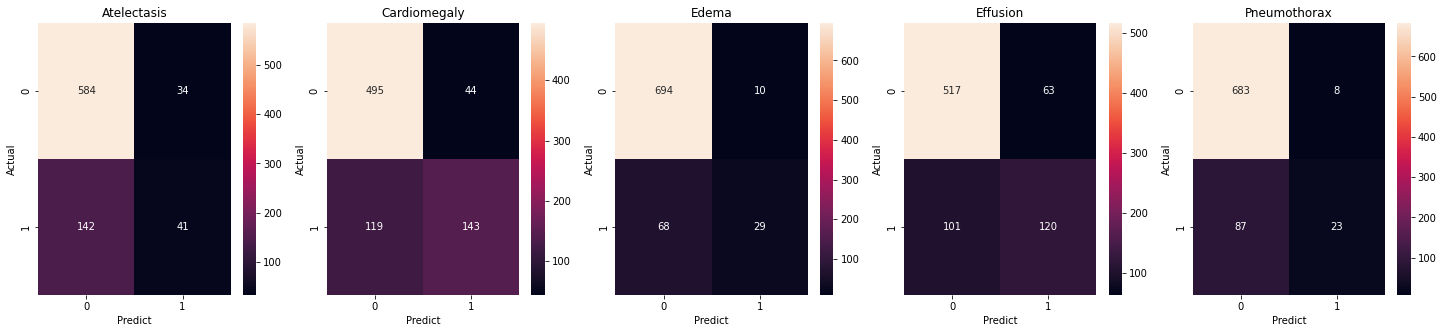

In [65]:
fig, ax = plt.subplots(1,5,figsize=(25,5))
for i in range(n_labels):
    sns.heatmap(multilabel_confusion_matrix(y_test==1,y_pred>=0.5)[i], annot=True, fmt='g', ax=ax[i])
    ax[i].set_title(labels_col[i])
    ax[i].set_xlabel("Predict")
    ax[i].set_ylabel("Actual")